In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def add_label_noise(labels, p=0.1):
    num_labels = int(len(labels))
    num_change = int(p * len(labels))
    
    idx = torch.randperm(num_labels)[:num_change]

    new_labels = torch.randint(0, 10, (num_change,))
    labels[idx] = new_labels
    return labels
print(add_label_noise(torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0]), 0.8))

trainset.targets = add_label_noise(torch.tensor(trainset.targets), p=0.15).tolist()

tensor([7, 2, 8, 4, 0, 8, 1, 2, 9, 0])


In [5]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
                                
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

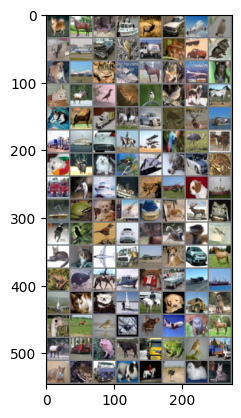

dog   ship  deer  ship  deer  car   plane bird  deer  plane frog  bird  truck frog  car   dog   frog  plane frog  ship  horse frog  plane dog   dog   deer  bird  frog  plane bird  dog   horse dog   horse truck horse car   frog  deer  cat   truck ship  car   horse plane bird  car   truck dog   deer  dog   bird  plane dog   car   deer  truck bird  ship  ship  frog  plane dog   ship  frog  frog  dog   plane car   deer  cat   frog  dog   bird  bird  car   deer  horse bird  plane horse cat   plane truck plane dog   car   horse frog  bird  horse dog   car   car   plane ship  plane cat   dog   ship  frog  dog   truck horse bird  horse horse plane cat   plane horse horse deer  car   frog  horse truck frog  bird  truck cat   frog  truck dog   frog  bird  dog   cat  


In [6]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
from resnet import ResNet

In [8]:
def estimate_loss(net, split="train"):
    if split == "train":
        loader = trainloader
    else:
        loader = testloader
    loss = 0
    net.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += F.cross_entropy(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
    net.train()
    return loss / len(loader)

In [9]:
def run_experiment(k=64, epochs=10):
    net = ResNet(k).to(device)
    n_params = sum(p.numel() for p in net.parameters())
    print(f'Width: {k}')
    print(f'Number of parameters: {n_params}')

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

    test_lossi = []
    lossi = []

    test_loss = estimate_loss(net, "test")
    test_lossi.append(test_loss)

    train_loss = estimate_loss(net, "train")
    lossi.append(train_loss)

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                print(f'[{epoch + 1}, {i + 1:5d}] running loss: {running_loss / 100:.3f}, loss: {loss.item():.3f}')
                lossi.append(running_loss / 100)
                running_loss = 0.0
        
        test_loss = estimate_loss(net, "test")
        test_lossi.append(test_loss)
        print(f'[{epoch + 1}] test loss: {test_loss:.3f}')
    
    return net, lossi, test_lossi


In [10]:
# testing
# net, lossi, test_lossi = run_experiment(16, 5)

In [11]:
# plt.plot(lossi, torch.arange(len(lossi)) / len(test_lossi), label='train')
# xs = torch.arange(len(lossi)) * ((len(test_lossi) - 1) / (len(lossi) - 1))
# print(len(lossi), len(test_lossi))
# print(xs, len(xs))
# # plt.plot(lossi, xs, label='train')
# plt.plot(xs, lossi)
# plt.plot(test_lossi, label='test')
# plt.legend()
# plt.show()

In [12]:
epochs = 512 
sizes = list(range(4, 33, 4))
print("sizes:", sizes)

losses = {}

for size in sizes:
    print(f'Running experiment with width {size}')
    net, lossi, test_lossi = run_experiment(size, epochs)
    losses[size] = (lossi, test_lossi)

    print(f'Finished experiment with width {size}')
    print('\n\n\n\n\n')
    del net

sizes: [4, 8, 12, 16, 20, 24, 28, 32]
Running experiment with width 4
Width: 4
Number of parameters: 44570
[1,   100] running loss: 2.272, loss: 2.246
[1,   200] running loss: 2.199, loss: 2.116
[1,   300] running loss: 2.108, loss: 2.031
[1] test loss: 1.872
[2,   100] running loss: 1.961, loss: 1.931
[2,   200] running loss: 1.911, loss: 1.839
[2,   300] running loss: 1.890, loss: 1.841
[2] test loss: 1.695
[3,   100] running loss: 1.845, loss: 1.882
[3,   200] running loss: 1.848, loss: 1.864
[3,   300] running loss: 1.807, loss: 1.983
[3] test loss: 1.606
[4,   100] running loss: 1.787, loss: 1.795
[4,   200] running loss: 1.775, loss: 1.706
[4,   300] running loss: 1.770, loss: 1.695
[4] test loss: 1.560
[5,   100] running loss: 1.736, loss: 1.757
[5,   200] running loss: 1.745, loss: 1.753
[5,   300] running loss: 1.736, loss: 1.713
[5] test loss: 1.515
[6,   100] running loss: 1.709, loss: 1.662
[6,   200] running loss: 1.711, loss: 1.621
[6,   300] running loss: 1.707, loss: 1.

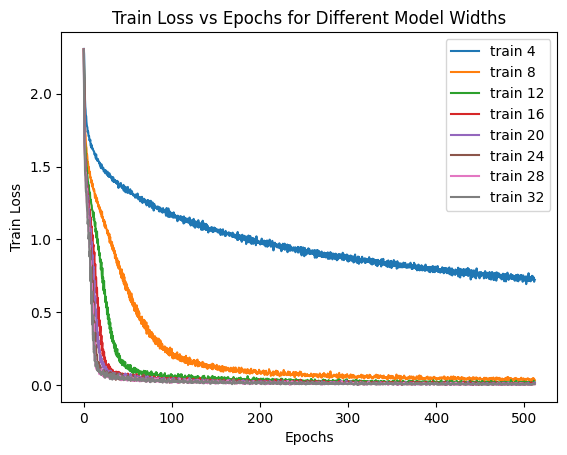

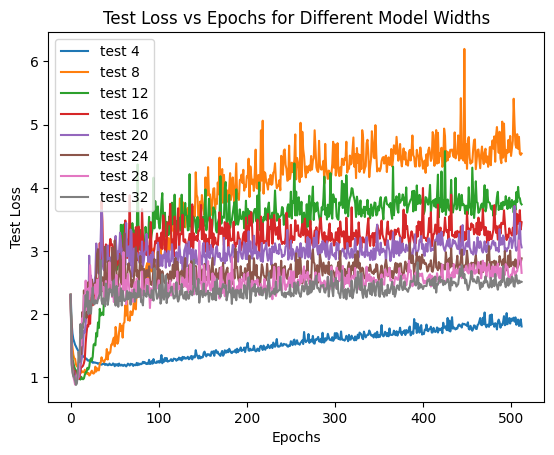

In [13]:
for size in sizes:
    lossi, test_lossi = losses[size]
    xs = torch.arange(len(lossi)) * ((len(test_lossi) - 1) / (len(lossi) - 1))
    plt.plot(xs, lossi, label=f'train {size}')

plt.title('Train Loss vs Epochs for Different Model Widths')
plt.ylabel('Train Loss')
plt.xlabel('Epochs')

plt.legend()
plt.show()


for size in sizes:
    lossi, test_lossi = losses[size]
    plt.plot(test_lossi, label=f'test {size}')

plt.title('Test Loss vs Epochs for Different Model Widths')
plt.ylabel('Test Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

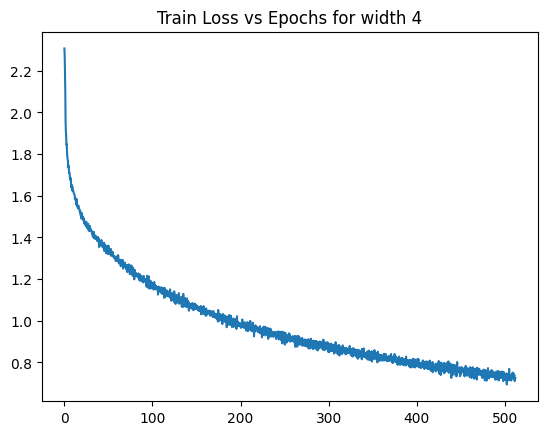

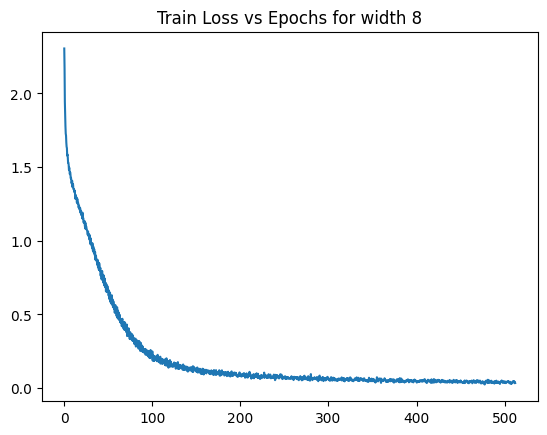

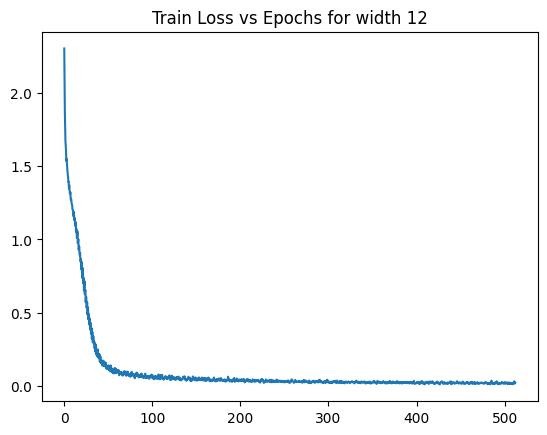

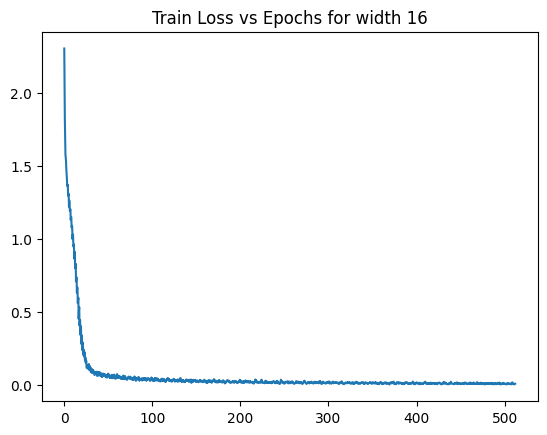

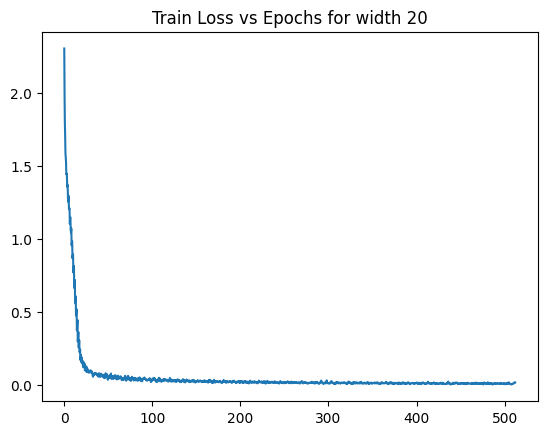

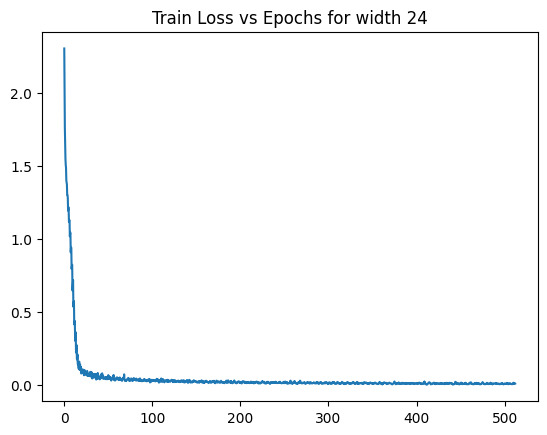

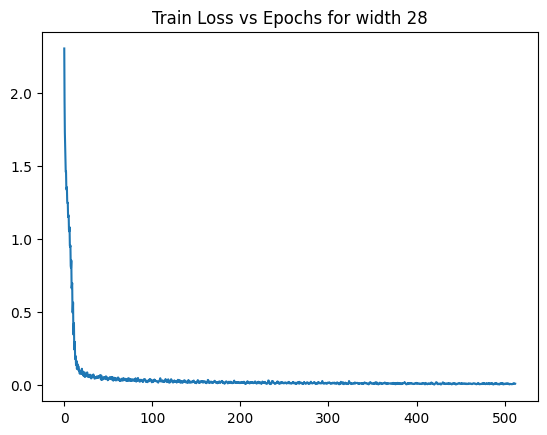

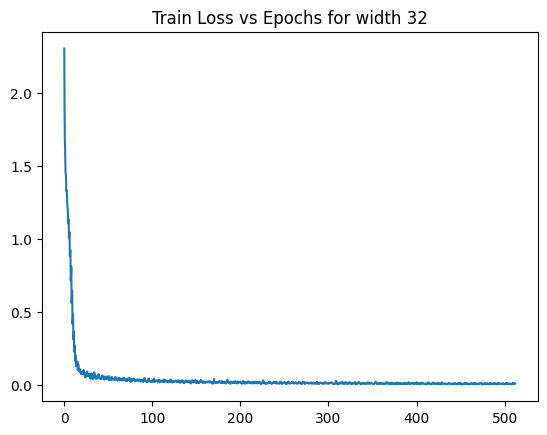

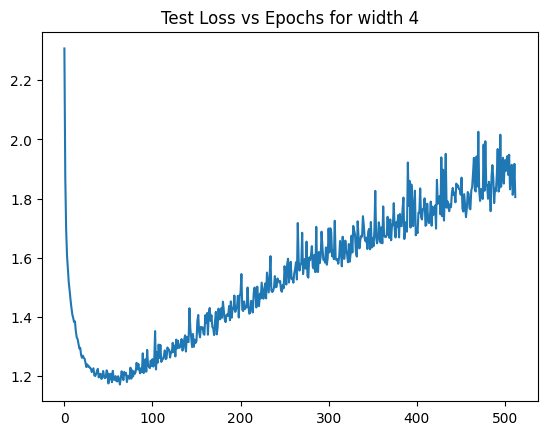

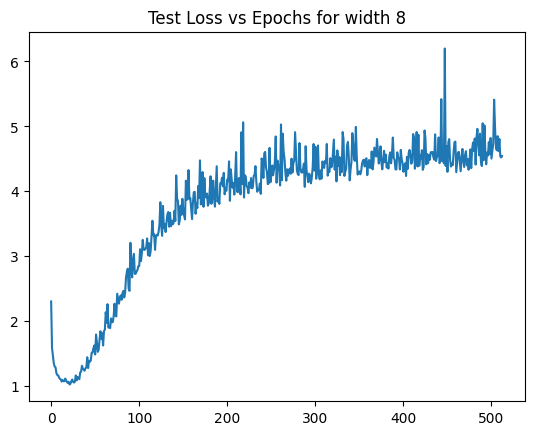

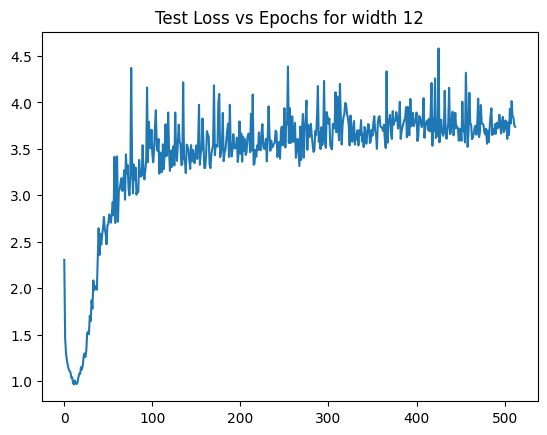

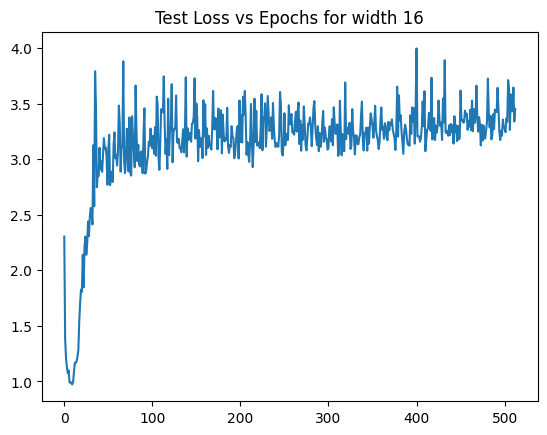

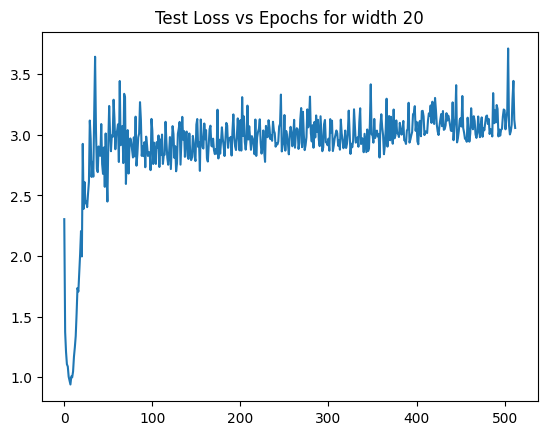

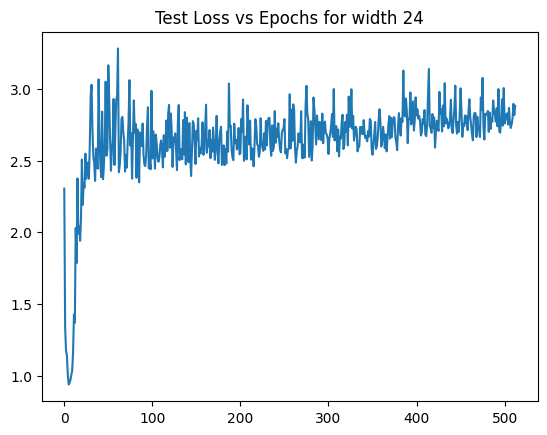

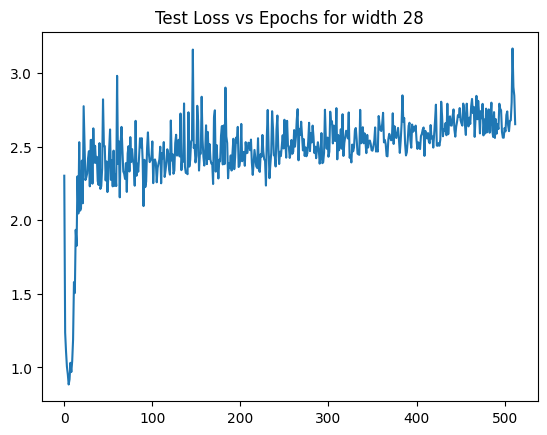

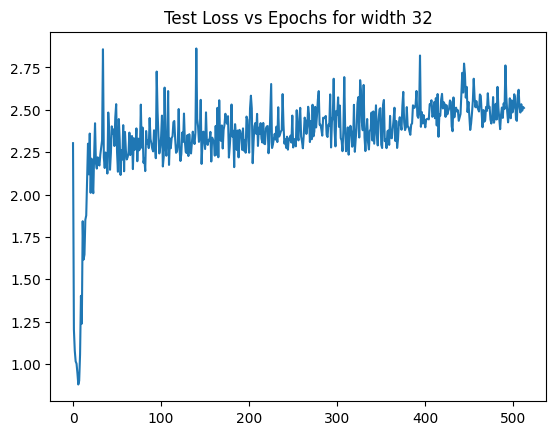

In [20]:
for size in sizes:
    lossi, test_lossi = losses[size]
    xs = torch.arange(len(lossi)) * ((len(test_lossi) - 1) / (len(lossi) - 1))
    plt.plot(xs, lossi, label=f'train {size}')
    plt.title(f'Train Loss vs Epochs for width {size}')
    plt.show()
    
for size in sizes:
    lossi, test_lossi = losses[size]
    plt.plot(test_lossi, label=f'test {size}')
    plt.title(f'Test Loss vs Epochs for width {size}')
    plt.show()

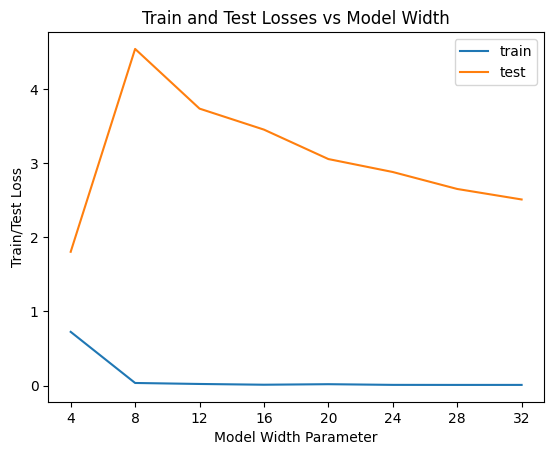

In [14]:
last_test_losses = [losses[size][1][-1] for size in sizes]
last_train_losses = [losses[size][0][-1] for size in sizes]

plt.title("Train and Test Losses vs Model Width")
plt.plot(sizes, last_train_losses, label='train')
plt.plot(sizes, last_test_losses, label='test')

plt.xticks(sizes)
plt.xlabel('Model Width Parameter')
plt.ylabel('Train/Test Loss')

plt.legend()
plt.show()

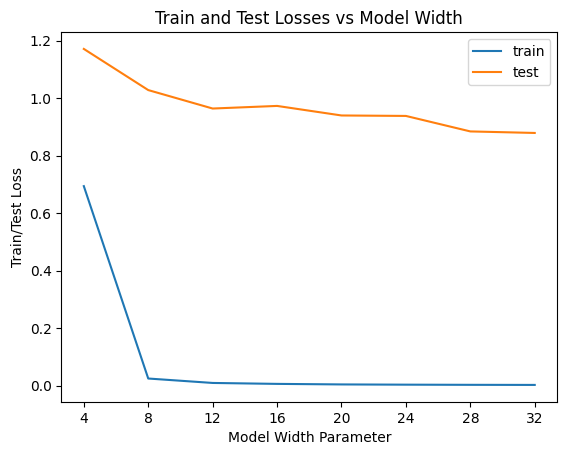

In [15]:

last_test_losses = [min(losses[size][1]) for size in sizes]
last_train_losses = [min(losses[size][0]) for size in sizes]

plt.title("Train and Test Losses vs Model Width")
plt.plot(sizes, last_train_losses, label='train')
plt.plot(sizes, last_test_losses, label='test')

plt.xticks(sizes)
plt.xlabel('Model Width Parameter')
plt.ylabel('Train/Test Loss')

plt.legend()
plt.show()